# Introduction 

This Jupyter Notebook contains all the codes and methodologies utilised to undertake and fulfil the instructions provided in part 2 of `main.pdf`, i.e. baseline.

Our aim is to implement LLMTIME procedure, we took into account one of the files provided in this repository, [llmtime.pdf](https://github.com/MatteoMancini01/M2_Cw/blob/main/instructions/llmtime.pdf). We were provided with two Python files `qwen.py` and `lora_skeleton.py`.  We created two extra Python files, `plotting.py` and `preprocessor.py`.  All Python files are stored in the directory `src`, the table below illustrates the purposes of each Python file, in `src`:

|File Name| Information|
|---------|------------|
|[`qwen.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/qwen.py)| Loads the Qwen2.5-0.5B-Instruct model and tokenizer from Hugging Face, freezes all model parameters except for the LM head bias, and prepares it for inference or fine-tuning.|
|[`lora_skeleton.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/lora_skeleton.py)| Implements LoRA (Low-Rank Adaptation) by wrapping the query and value projection layers of the Qwen2.5 model with trainable LoRA layers, processes the Lotka-Volterra dataset using LLMTIME, tokenizes it, and fine-tunes the model for up to 10,000 optimizer steps using PyTorch and accelerate.​|
|[`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py)| Contains the class `Preprocessor`, which gives access to all the functions required for preprocessing the dataset from `lotka_volterra_data.h5`, this includes functions that scale data, converts array to string and sting back to array, all very useful pre-requisites for preprocessing the dataset.|
|[`plotting.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/plotting.py)|This file is not one of the requisites for this project. Designed for plotting. File contains a class PlotProject, which contains all the plotting functions required for the Jupyter Notebooks, this aims to keep the Notebooks tidy.|

For more details about each Python files, I encourage the reader to inspect them, each function within all files, have detailed doc-stings including examples on how to use them.


Through out this Notebook to run codes certain packages and designed functions are required, please make sure you run the following cell!

In [1]:
# Import required packages
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from src.preprocessor import Preprocessor
from src.qwen import load_qwen, tokenize_time_series 
from src.plotting import PlotProject
from sklearn.metrics import mean_absolute_error


scaling_operator = Preprocessor.scaling_operator # Set scaling_operator to function 
model, tokenizer = load_qwen() # Set model = model and tokeinzer = tokenizer
array_to_string = Preprocessor.array_to_string # Importing array_to_string(data) to convert timeseries to string
string_to_array = Preprocessor.string_to_array # Importing string_to_array(formatted_string) to convert strings back to arrays

plot_hist_MSE = PlotProject.plot_hist_MSE # Set function designed to plot MSE histograms
plot_hist_RMSE = PlotProject.plot_hist_RMSE # Set function designed to plot RMSE histograms
plot_pred_vs_true = PlotProject.plot_pred_vs_true # Set function to plot predicted vs true system
plot_error_hist_system = PlotProject.plot_error_hist_system # Plot distribution of error in each system


/root/Document/Term2/M2/M2_Cw/m2_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-19 19:09:13.178799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742411353.266069   52048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742411353.291922   52048 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 19:09:13.504334: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance

This procedure takes a while to run with `model.generate()`, thus, we collected all of Qwen2.5 outcomes and the relevant metrics into the directory `saved_predictions_2b`. The reader is welcome to run the cell below for loading all the relevant metrics.

In [3]:
# Load decoded predictions generated from Qwen2.5, npz file
loaded = np.load("saved_predictions_2b/my_decoded_predictions.npz")
my_decoded_predictions = [loaded[key] for key in loaded]

# Load MSE and RMSE for each system, these are csv files
mse_true_predicted_loaded = pd.read_csv("saved_predictions_2b/mse_true_predicted.csv")
rmse_true_predicted_loaded = pd.read_csv("saved_predictions_2b/rmse_true_predicted.csv")

# Load error computed between true and predicted pairs prey and predator, npz file
loaded_error = np.load("saved_predictions_2b/error_per_system.npz")
error_per_system_loaded = [loaded_error[key] for key in loaded_error]

Open `lotka_volterra_data.h5` file on notebook

In [4]:
with h5py.File('lotka_volterra_data.h5', 'r') as f:
    # Access the full dataset
    trajectories = f['trajectories'][:]
    time_points = f['time'][:]

Checikng shape of the dataset, we expect trajectories to be of size $(1000 \times 100 \times 2)$, and time_points of size $(100 \times 1)$

In [5]:
print('Time points shape:',time_points.shape)
print('')
print('Trajectory shape (pray/predator):',trajectories.shape)

Time points shape: (100,)

Trajectory shape (pray/predator): (1000, 100, 2)


The table below illustrate `lotka_volterra_data.h5`(using `pandas.DataFrame`to cunstruct the table).

In [7]:
num_systems, num_time_steps, num_variables = trajectories.shape

def repeat_sequence(seq, n):
    '''  
    Repeats the given sequence `n` times and returns the concatenated list.

    Parameters:
    seq (list): The sequence to be repeated.
    n (int): The number of times to repeat the sequence.

    Returns:
    list: A new list containing the repeated sequence.
    '''
    repeated_list = seq*n 
    return repeated_list

# Create a DataFrame
df_traj = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems), num_time_steps),  # Repeats 0-999, each 100 times
    "time_step": repeat_sequence(time_points.tolist(), num_systems), # Cycles 0-99 for each system
    "prey": trajectories[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories[:, :, 1].flatten()  # Flatten predator values
})
df_traj # Visualising data in dataframe format

,system_id,time_step,prey,predator
0,0,0.000000,0.949917,1.040624
1,0,2.020202,0.740551,0.779542
2,0,4.040404,0.682246,0.564390
3,0,6.060606,0.716674,0.407644
4,0,8.080808,0.824511,0.300283
...,...,...,...,...
99995,999,191.919192,0.901549,0.579420
99996,999,193.939394,0.957527,0.539055
99997,999,195.959596,1.036460,0.515615
99998,999,197.979798,1.129212,0.510619


# Part 2 (a)

Grouping prey and predator into arrays to determine the maximum value for scaling procedure.

In [8]:
prey_array = trajectories[:,:,0].flatten()
predator_array = trajectories[:,:,1].flatten()

## Scaling Dataset `lotka_volterra_data.h5`

As we will see in the `Table` presented below, in the original dataset we have laues that vary significantly. To standardize the numeric range, we are going to use [quantiles]( https://en.wikipedia.org/wiki/Quantile). A quantile is a value that divides a dataset into equal-sized intervals, indicating the data points below which a given percentage if observations fall. From the project instructions it is adviced to apply a simple scaling:
$$
x_t' = \frac{x_t}{\alpha}
$$
where $\alpha$ should be chosen based on the distribution of the dataset `lotka_volterra_data.h5`.

In our particular case we want most of our dataset to be in range $[0,10]$. This is coded in the [`preprocessor.py`](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py) file, which appropriate docstrings.

#### `numpy.quantile()`

For scaling our dataset we want to use [`numpy.quantile()`](https://numpy.org/doc/2.1/reference/generated/numpy.quantile.html). The `numpy.quantile()` function calculates the quantiles of a given NumPy array. Quantiles are cut points that devide the data into intercals with equal probability. Thus `numpy.quantile()`can be used to scale our dataset dynamically, without having to worry about choosing the appropriate value for $\alpha$.

All of this is implemented in the function `scaling_operator`, which also <b>rounds</b> each datapoint using `numpy.round()`, this is set to 3 decimal places.

Scaling data

In [9]:
trajectories_scaled, scaling_factor = scaling_operator(trajectories, 0.9, 10) # Using function from preprocessor
print('Scaling factor:', scaling_factor)

# Collecting prey and predator in separate arrays
prey_array_scaled = trajectories_scaled[:,:,0].flatten()
predator_array_scaled = trajectories_scaled[:,:,1].flatten()

Scaling factor: 0.25283724


Collecting scaled data into `pandas.DataFrame` format, in particular, we want to construct a $100000\times 4$ table, (number of rows $= 1000 \times 100$). With four colums, of which three are `time_step`, `prey` and `predator`, but with an additional one `system_id` (this separates the $1000$ different systems), which will be later used to convert our timeseries data into string format.

In [10]:
num_systems_scaled, num_time_steps_scaled, num_variables_scaled = trajectories_scaled.shape

# Create a DataFrame
df_traj_scaled = pd.DataFrame({
    "system_id": np.repeat(np.arange(num_systems_scaled), num_time_steps_scaled),  # Repeats 0-999, each 100 times
    "time_step": repeat_sequence(time_points.tolist(), num_systems_scaled), # Cycles 0-99 for each system
    "prey": trajectories_scaled[:, :, 0].flatten(),  # Flatten prey values
    "predator": trajectories_scaled[:, :, 1].flatten()  # Flatten predator values
})
# Visualising table
df_traj_scaled

,system_id,time_step,prey,predator
0,0,0.000000,3.757,4.116
1,0,2.020202,2.929,3.083
2,0,4.040404,2.698,2.232
3,0,6.060606,2.835,1.612
4,0,8.080808,3.261,1.188
...,...,...,...,...
99995,999,191.919192,3.566,2.292
99996,999,193.939394,3.787,2.132
99997,999,195.959596,4.099,2.039
99998,999,197.979798,4.466,2.020


Defining a function that calculates the percentage of values in an array that fall outside a given range. (This seem tedious, as we set a value for quantile in the function `scaling_operator`, e.g. $q = 0.9$, means that only $10%$ of the values will be out of our custom range. But this will be used to measure what percentage of datapoints in the original dataset is outside a specific range.)

In [11]:
def scaling_measure(arr, min_val, max_val):
    
    """
    Calculates the percentage of values in an array that fall outside a given range.

    Parameters:
    -----------
    arr : array-like
        The input numerical data.
    min_val : float
        The minimum acceptable value.
    max_val : float
        The maximum acceptable value.

    Returns:
    --------
    str
        The percentage of values outside the range, formatted as a string.
    """

    # Count values about the max range
    outside_count = np.sum((arr < min_val)|(arr > max_val))

    # Calculating the pergentage of values outside max range
    percentage_outside = (outside_count/arr.size)*100

    return f'{percentage_outside:.2f}%'

Collecting scaling information into a Table using `pandas.DataFrame`.

In [12]:
min_val = 0
max_val = 1
Table_1 = pd.DataFrame({

    'Pray': [max(prey_array), np.mean(prey_array), min(prey_array), scaling_measure(prey_array, min_val, max_val)],
    'Pray after scaling': [max(prey_array_scaled), np.mean(prey_array_scaled), min(prey_array_scaled), scaling_measure(prey_array_scaled, min_val, max_val)],
    'Predator': [max(predator_array), np.mean(predator_array), min(predator_array), scaling_measure(predator_array, min_val, max_val)],
    'Predator after scaling': [max(predator_array_scaled), np.mean(predator_array_scaled), min(predator_array_scaled), scaling_measure(predator_array_scaled, min_val, max_val)],
    
})
Table_1.index = ["Maximim Value", "Mean Value", "Minimum Value", f"Values outside the range {min_val}-{max_val}"] # Adding index for each row

 From the table below, we can observe, scaling was successful. The reason why we want to test how many data points are outside the range $[0,1]$, is due to the fact that a lot of data points in the original dataset (pre-scaling) are very small, many of order $10^{-3}$ (and smaller order $10^{-4}$), which may affect the tokenisation process.

In [13]:
Table_1 # Visualising table

,Pray,Pray after scaling,Predator,Predator after scaling
Maximim Value,13.740113,54.344002,4.76849,18.860001
Mean Value,1.698114,6.71623,0.569606,2.252858
Minimum Value,0.002077,0.008,0.000037,0.0
Values outside the range 0-1,63.11%,93.82%,12.21%,77.31%


Looking at the last row, we can see that we have a major improvement for both `prey` and `predator` categories, the percentage of values outside the range $[0,1]$ has increased in `prey` by ~ $30\%$ and `predator` by ~ $65\%$. Thus, scaling was successful. Now we can proceed with the next step, i.e. converting the scaled dataset to strings, for compatibility with [Qwen2.5]( https://github.com/QwenLM/Qwen2.5).

## Qwen2.5 (Demo)

Trying with examples provided at the end of project instructions, see [LLMTIME Preprocessing Scheme](https://github.com/MatteoMancini01/M2_Cw/blob/main/instructions/main.pdf).

In [14]:
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0]) # Tokenising string 1.23
print('')
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0]) # Tokenising string 1 . 2 3

[16, 13, 17, 18]

[16, 659, 220, 17, 220, 18]


Note: from the above output one can observe, space between each numbers and dot changes the size of tokenisation output, together with the size of each token. 

Example of how `load_qwen()` works!

In [15]:
text = 'Hello, world' # Define input text
input_ids = tokenizer(text, return_tensors='pt').input_ids # Tokenize text 
output = model.generate(input_ids, max_length = 50) # Generate output

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


From the above code line 3 `output`, the variable `max_length` determines how many more words will the model predict when inputing text, e.g. `text = Hello, world`, as we can see from the below output.

In [16]:
output # Visualising output

tensor([[ 9707,    11,  1879,     0,  2585,   646,   358,  1492,   498,  3351,
            30,  5209,  3410,   752,   448,   279,  5871,  1995,   311,  7789,
           498,    13,  3555,  1035,   498,  1075,   311,  1414,   476,   653,
          1939,  2121,   458, 15235,  4128,  1614,    11,   358,  1513,   944,
           614,   264,  6961,  9362,   323,  4157, 16282,  5961,   448,  3847]])

From the above tensor we recognise that the first 3 tokens are related to our text, the rest of the tokens is predicted text determined from the model, as we will see below when decoding `output`.

<b>Decoding `output`</b>

In [17]:
print(tokenizer.decode(output[0], skip_special_tokens=True)) # Decoding output

Hello, world! How can I help you today? Please provide me with the necessary information to assist you. What would you like to know or do?

As an AI language model, I don't have a physical presence and cannot interact directly with users


## Converting Scaled Dataset into Strings

We now have seen how tokenisation for text works! There is a small issue, Qwen2.5 is only designed to convert text, i.e. strings in Python, to tokens, while our dataset is a timeseries composed of 2 variables prey and predator over a time series of size 100, this is repated for a 1000 samples. Thus, before we proceed with tokenisation, we require to convert the time series data into sets of strings. To do so we are going to define a fucntion `array_to_string(data)`, and a function to convert string to array `sring_to_array(formatted_string)` (both functions are in [preprocessor.py](https://github.com/MatteoMancini01/M2_Cw/blob/main/src/preprocessor.py)).

⚠ Note: The function `array_to_string` is specifically designed for the dataset `lotka_volterra_data.h5`, in particular after converting `trajectories` into a `panda.DataFrame` format, with columns `system_id` (labeling each system from 0 to 999), columns `prey` and `predator`, each  displaying 100 data points for every `system_id`.

In [18]:
traject_scaled_string = array_to_string(df_traj_scaled) # Converting df_traj_scaled into string format

Checking result post-conversion

In [19]:
ID = 0 # Change value (0-999) to visualise a different string
print(f'Trajectory string format with system ID = {ID}:', traject_scaled_string[ID])

Trajectory string format with system ID = 0: 3.757,4.116;2.929,3.083;2.698,2.232;2.835,1.612;3.261,1.188;3.973,0.909;4.995,0.736;6.35,0.642;8.033,0.611;9.978,0.64;12.027,0.741;13.915,0.938;15.283,1.271;15.732,1.785;14.933,2.492;12.876,3.282;10.089,3.882;7.451,4.015;5.574,3.666;4.52,3.066;4.08,2.448;4.068,1.929;4.385,1.536;4.991,1.259;5.869,1.081;7.002,0.986;8.344,0.963;9.801,1.013;11.212,1.145;12.356,1.373;12.979,1.715;12.864,2.165;11.941,2.672;10.379,3.118;8.59,3.351;7.014,3.296;5.897,3.004;5.265,2.6;5.044,2.193;5.154,1.845;5.539,1.577;6.165,1.389;6.997,1.277;7.985,1.235;9.047,1.263;10.065,1.363;10.892,1.539;11.366,1.792;11.36,2.108;10.829,2.451;9.87,2.75;8.698,2.927;7.569,2.934;6.673,2.781;6.095,2.527;5.834,2.238;5.856,1.969;6.119,1.748;6.586,1.585;7.217,1.485;7.96,1.445;8.747,1.465;9.484,1.546;10.065,1.686;10.389,1.879;10.378,2.11;10.015,2.349;9.366,2.551;8.563,2.672;7.76,2.684;7.09,2.589;6.629,2.419;6.4,2.215;6.395,2.013;6.589,1.84;6.95,1.709;7.44,1.626;8.01,1.593;8.602,1.611;9.141

We also want to test the function `string_to_array`, this is done below for the first `system_id` string data format, i.e. `system_id` $ = 0$.

In [20]:
print('Testing string_to_array:',string_to_array(traject_scaled_string[ID])[0])

Testing string_to_array: [3.757 4.116]


As we can observe from the above output, we successfully converted string back to array.
Note, we only output the first element of the list, to avoid over-writing the notebook with useless outcomes!

## Tokenisation 

We provided few basic examples on how to use `load_qwen()` in section 2.11, with some text and numbers (string form). We now want to proceed and tokenise our data, to achieve this, we designed a function for our particular needs that uses `model, tokenizer = load_qwen()`.


In [21]:
tokenised_data = tokenize_time_series(traject_scaled_string) # Tokenising data
ID = 0 # Change value (0-999) to visualise a different string
print(f'Trajectory string format with system ID = {ID}:', tokenised_data[ID])

Trajectory string format with system ID = 0: {'input_ids': tensor([[18, 13, 22,  ..., 16, 16, 22]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]])}


Closer look at two examples:

In [22]:
# Print tokenised output for the first system
print('Two examples of tokens from tokenised_data:')
print('')
print('Preprocessed data:')
print(traject_scaled_string[3])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[3]["input_ids"].squeeze().tolist())  # Tokenised tensor
print('Length of the above token:',len(tokenised_data.iloc[3]["input_ids"].squeeze().tolist()))  # Tokenised tensor
print('')
print('')
print('Preprocessed data:')
print(traject_scaled_string[990])
print('')
print('After tokenisation:')
print(tokenised_data.iloc[990]["input_ids"].squeeze().tolist())
print('Length of the above token:',len(tokenised_data.iloc[990]["input_ids"].squeeze().tolist()))

Two examples of tokens from tokenised_data:

Preprocessed data:
4.115,4.567;2.628,4.406;1.746,3.903;1.283,3.281;1.064,2.682;0.985,2.167;1.001,1.747;1.097,1.415;1.276,1.159;1.55,0.967;1.943,0.829;2.482,0.737;3.2,0.687;4.123,0.678;5.257,0.716;6.562,0.815;7.924,0.998;9.13,1.307;9.86,1.792;9.749,2.494;8.564,3.374;6.523,4.207;4.348,4.651;2.719,4.538;1.766,4.031;1.271,3.387;1.035,2.764;0.945,2.226;0.951,1.787;1.036,1.44;1.201,1.173;1.456,0.973;1.825,0.827;2.337,0.728;3.024,0.67;3.917,0.652;5.029,0.68;6.335,0.763;7.739,0.925;9.045,1.203;9.947,1.649;10.062,2.316;9.091,3.192;7.12,4.099;4.814,4.678;2.985,4.677;1.89,4.211;1.314,3.563;1.034,2.913;0.918,2.344;0.904,1.876;0.969,1.505;1.11,1.218;1.338,1.001;1.671,0.841;2.137,0.73;2.772,0.661;3.609,0.631;4.669,0.644;5.946,0.706;7.369,0.838;8.777,1.073;9.892,1.46;10.333,2.058;9.727,2.895;7.978,3.859;5.6,4.616;3.489,4.82;2.134,4.464;1.414,3.824;1.061,3.142;0.904,2.528;0.861,2.019;0.9,1.612;1.013,1.295;1.205,1.054;1.493,0.875;1.904,0.747;2.469,0.663;3.22

Summary of <b>Part 2 (a)</b>:

- Load the predator-prey dataset from the `lotka_volterra_data.h5` file.
- Applied the LLMTIME preprocessing scheme, this includes:
    - Scale the numaric values using the fucntion ` scaling_operator` (in file `preprocessor.py`).
    - Round the values to a fixed number of decimal places (we have used 3 d.p.).
    - Converted the sequences into formatted strings using:
        - Commas to separate variables at each timestep.
        - Semicolons to separate different timesteps.
        - Collection of every system.
- Tokenised the processed sequences using the Qwen2.5 tokeniser.  

# Part 2 (b)

This section aims to evaluate the performance of the untrained Qwen2.5-Instruct model's forecasting ability on the tokenised dataset, i.e. `tokenised_data` from Part 2(a) (previus section).

Due to lack of computational power and limited number of FLOPS available for this project, we are not going to invest much time to this part. To save time and FLOPS we are only going to consider a subset of the dataset, $10\%$ of our original dataset, i.e. 100 systems out of the available 1000.

Approach to the problem:

1. Select the first 100 system from our dataset.
2. Select the first 50 data points from each of the 100 selected systems
3. Tokenise the selected subset.
4. Use `model.generate` to predict and decode the remaining 50 pairs of datapoints.
5. Convert back to tameseries data.
6. Visualise: select one of the predictions and plot them against actual data.
7. Measure error predicted vs real data, for each of the 100 selected systems.

After completing all the above steps, we can analyse and comment on the results.

#### Steps 1 \& 2
Select the first 100 system from our dataset, of which the first 50 data points from each of the 100 selected systems.

The easiest approach is to work with `df_traj_scaled` (`pandas.DataFrame` format). Easy to select 100 system and cut off the last half of the data-points (prey, predator).

In [23]:
# Step 1: Keep only the first 100 system_ids
df_filtered = df_traj_scaled[df_traj_scaled['system_id'] < 100]  

# Step 2: Remove last 50 rows for each system_id
df_sub_traj_scaled = df_filtered.groupby('system_id').apply(lambda x: x.iloc[:-50]).reset_index(drop=True)

/tmp/ipykernel_52048/2856005867.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sub_traj_scaled = df_filtered.groupby('system_id').apply(lambda x: x.iloc[:-50]).reset_index(drop=True)


#### Step 3
<b>Tokenise the selected subset</b>:

Recall Part 2(a): before tokenisation we had to convert data into string, we used the function `array_to_string` from `preprocessor.py`. Ultimately we tokenised the converted dataset with the function `tokenize_time_series` from `qwen.py`. Here we are going to repeat the same process.

In [24]:
str_sub_traj_scaled = array_to_string(df_sub_traj_scaled) # Converting subset of Timeseries data into str  
tok_sub_traj_scaled = tokenize_time_series(str_sub_traj_scaled) # Tokenising sub-dataset

Below a basic function to determone the max lenght of a tokenised sequence.

In [25]:
def max_sequence_length(tokenized_data):
    
    max_length = max(entry["input_ids"].shape[1] for entry in tokenized_data)

    return f'Max Sequence Length: {max_length}'

Comparing full dataset vs sub-dataset max sequence length

In [26]:
print('Full dataset:')
print(max_sequence_length(tokenised_data))
print('')
print('Sub-dataset:')
print(max_sequence_length(tok_sub_traj_scaled))

Full dataset:
Max Sequence Length: 1281

Sub-dataset:
Max Sequence Length: 633


As expected, from the above output the largest sequence of each tokenised dataset has dropped by ~ $\frac{1}{2}$.

#### Step 4
<b>Use `model.generate` to predict and decode the remaining 50 pairs of datapoints.</b>

We need to know the maximum lenght for each sequence in the tokenised sub-datased.

In [27]:
max_lengths = []  
range_model = 100

for i in range(range_model):
    input_ids = tok_sub_traj_scaled[i]["input_ids"]  # Extract the input IDs
    max_length = input_ids.shape[1]  # Get the length of the sequence
    max_lengths.append(max_length)  # Append only the integer value
print('List of sequence lengths:')
print(max_lengths)

List of sequence lengths:
[609, 613, 608, 590, 631, 586, 613, 596, 583, 586, 592, 607, 588, 585, 595, 589, 596, 604, 594, 605, 585, 588, 589, 594, 605, 588, 588, 589, 595, 600, 596, 632, 591, 592, 605, 600, 598, 604, 633, 609, 593, 591, 592, 603, 605, 599, 606, 582, 613, 590, 593, 583, 624, 589, 614, 591, 590, 611, 589, 590, 598, 592, 620, 623, 600, 614, 606, 589, 583, 601, 587, 604, 594, 588, 590, 604, 597, 596, 610, 605, 588, 583, 617, 587, 601, 597, 630, 588, 589, 595, 593, 604, 601, 586, 616, 588, 625, 587, 588, 609]


Collecting `input_ids` and `attention_mask` into `input_ids_list` and `attention_mask_list` respectivelly. 

In [28]:
input_ids_list = [tok_sub_traj_scaled[i]["input_ids"] for i in range(range_model)]
attention_masks_list = [tok_sub_traj_scaled[i]["attention_mask"] for i in range(range_model)]

Below we are using `model.generate` to predict the next 50 pairs (prey, predator), using the intrained Qwen2.5-Instruct model's forecasting ability on our tokenised data subset.

In [ ]:
output_list = []

for i in range(range_model):
    output = model.generate(input_ids_list[i], # Sequence, numerical tokens
                            attention_mask = attention_masks_list[i], # 
                            max_length = 2*max_lengths[i], # Maximum length of generated output
                            num_return_sequences=1, # Number of prediction to return per input
                            do_sample=True, # Enables sampling (i.e. introduces randomness)
                            temperature=0.7, # Controls randomness of predictions
                            top_p=0.8, # Nucleus sampling (filters low-probability tokens)
                            top_k=20 # Limits the number of token options at each step
                            )
    output_list.append(output)

Below we are decoding the predicted output and collecting it into `decoded_output_list`.

In [ ]:
decoded_output_list = []

for i in range(range_model):
    decoded_output = tokenizer.decode(output_list[i][0], skip_special_tokens=True)
    decoded_output_list.append(decoded_output)

#### Step 5

Converting strings output in `decoded_output_list` back into timeseries data.

In [ ]:
string_to_array_list = []

for i in range(range_model):
    decoded_to_number = string_to_array(decoded_output_list[i])
    string_to_array_list.append(decoded_to_number)

Saving encoded prediction, as to predict the next ~50 pair points in each of the 100 selected systems, required a run time of 140 minutes (~2h and 20 minutes). The file is saved as `my_decoded_predictions.npz`. I used `numpy.savez`, as `string_to_array_list` is a list of arrays.

In [ ]:
#my_decoded_predictions = string_to_array_list
#type(my_decoded_predictions)
#np.savez("my_decoded_predictions.npz", *my_decoded_predictions)

#### Step 6

Determining metrics:

- Mean Square Error (MSE).
- Root Mean Square Error (RMSE).
- Error of each pair of points for one system at the time.

#### MSE

Mean Square Error.

This is computed by determining the square difference between $\hat{y}_i$ (predicted values), and $y_i$ (true values), and take the average. For $n$ points:
$$
MSE = \frac{1}{n} \sum^{n}_{i=1} (y_i - \hat{y}_i)^2
$$

Since our input for `model.generate` where the first 50 pair point (prey, predator), when calculating the mean square error (MSE), we can remove the first 50 datapoints from our prediced output, as model provides input tokens $+$ predicted tokens. 

In [71]:
# Removing the first 50 input tokens and true values

predicted_output = []
true_values = []
for i in range(len(my_decoded_predictions)):
    sub_output = my_decoded_predictions[i]
    sub_output_min_50 = sub_output[50:]
    true_v = trajectories_scaled[i]
    true_v_min_50 = true_v[50:]
    predicted_output.append(sub_output_min_50)
    true_values.append(true_v_min_50)

In [ ]:
MSE_values = []


for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Compute the MSE
    mse_prey = mean_absolute_error(pr_out[:,0], true_val[:,0]) # Computing MSE for prey
    mse_predator = mean_absolute_error(pr_out[:,1], true_val[:,1]) # Computing MSE for predator
    MSE_values.append([mse_prey, mse_predator])


# Collecting everything into a dataframe
# Create a DataFrame
df_MSE_values = pd.DataFrame({
    "system_id": np.arange(len(MSE_values)),  
    "MSE for prey": np.array(MSE_values)[:, 0],  # Flatten prey values
    "MSE for predator": np.array(MSE_values)[:, 1]  # Flatten predator values
})
#df_MSE_values
#df_MSE_values.to_csv('mse_true_predicted.csv', index=False) # Saving as a csv using pandas

#### RMSE

Root Mean Square Error

To compute this simply take the root of each MSE. RMSE, in general, helps compare errors on the same scale as the data, i.e. linear.
$$
RMSE = \sqrt{MSE}
$$

In [77]:
# We already computed MSE all we have to do is to take the root of each value in MSE DataFrame
# Use np.sqrt() and .tolist() to compute RMSE using mse_true_predicted "saved MSE dataframe"
mse_true_predicted = mse_true_predicted_loaded
df_RMSE_values = pd.DataFrame({
    "system_id": mse_true_predicted['system_id'].tolist(),  
    "RMSE for prey": np.sqrt(mse_true_predicted['MSE for prey'].tolist()),  
    "RMSE for predator": np.sqrt(mse_true_predicted['MSE for predator'].tolist())  
})

# Saving the above DataFrame as a csv file
#df_RMSE_values.to_csv('saved_predictions_2b/rmse_true_predicted.csv', index=False)


#### Histogram of Error Mean

Here we want to visualise the distribution of errors (difference between predicted and true values). This can be done in differet ways (both executed):

- i. Per Time Step (Point-Wise Error Distribution):
    - Computing the error at each step:
    $$
    e_t = y_t - \hat{y}_t
    $$ 
    - There is a fucntion in `src.plotting`, namely `plot_error_hist_system`, used for plotting one histogram at the time related to a single system.
    - From visualising each histogram individually, one can check the distribution of errors.

In [ ]:
# Computing the error for each system

error_per_system = []

for i in range(len(true_values)):

    # Truncate to match the shorter list
    min_length = min(len(predicted_output[i]), len(true_values[i]))
    pr_out = predicted_output[i][:min_length]
    true_val = true_values[i][:min_length]

    # Computing errors
    prey_error = true_val[:,0] - pr_out[:,0]
    predator_error = true_val[:,1] - pr_out[:,1]
    
    # Collecting errors into a list
    error_per_system.append([prey_error, predator_error])

print('Length of error_per_system:',len(error_per_system))

# Saving system as 
#np.savez("saved_predictions_2b/error_per_system.npz", *error_per_system)

Length of error_per_system: 100


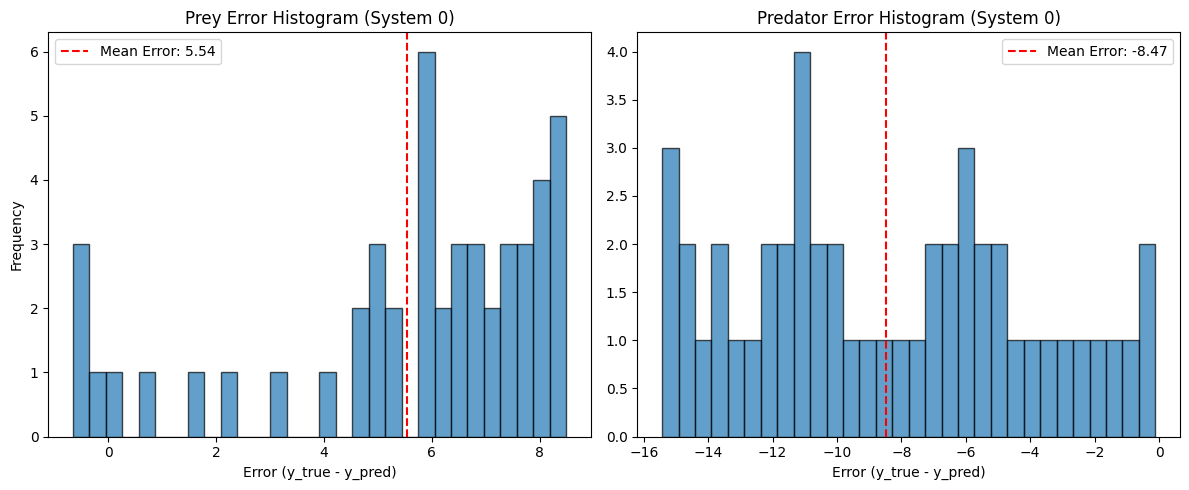

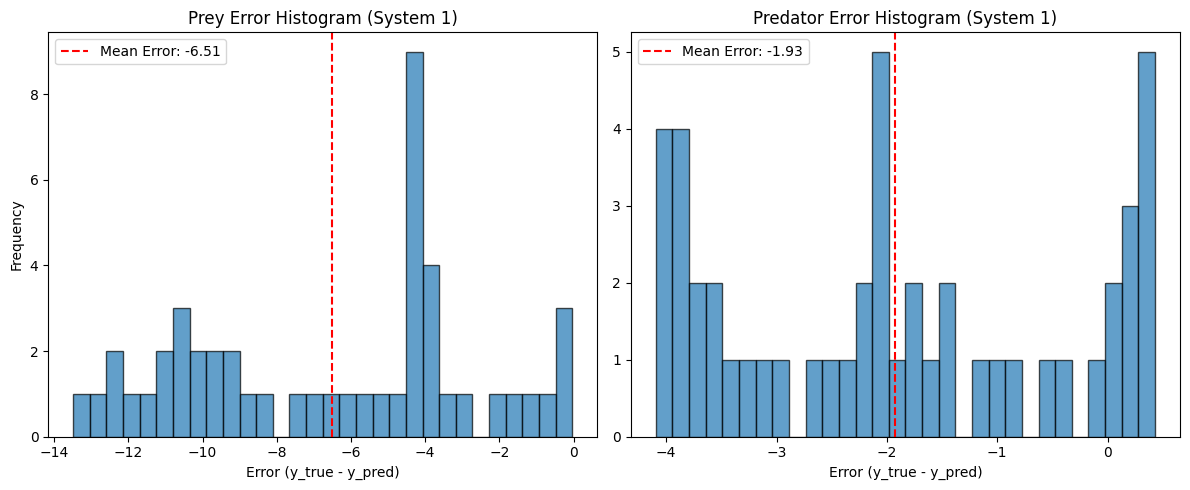

In [81]:
# Print as many historgrams as you want from 0-99.
for i in range(2):
    plot_error_hist_system(error_per_system_loaded, system_id=i, bins=30)

- ii. Per System (System-Level Error Distribution)

Plotting histogram on MSE

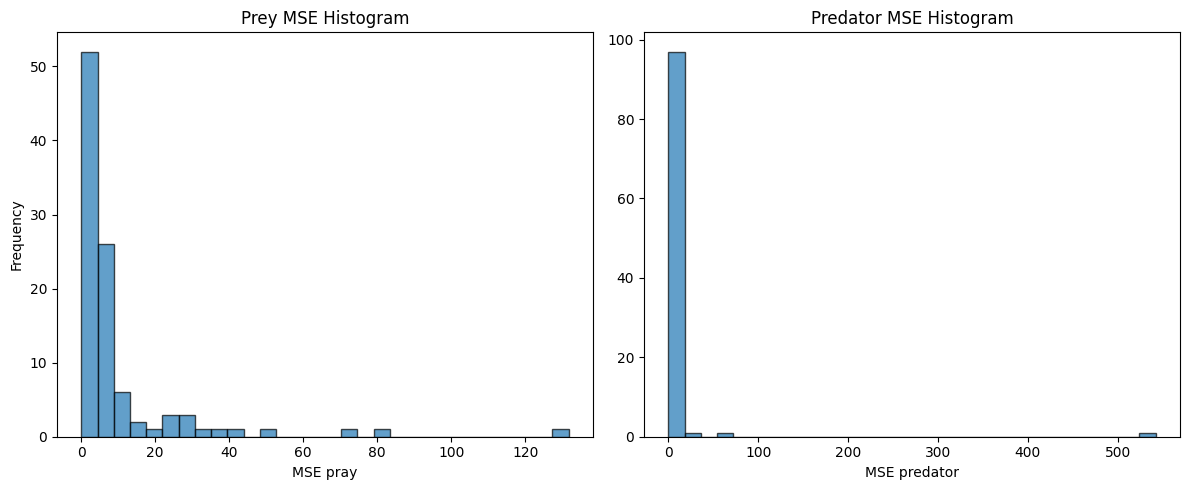

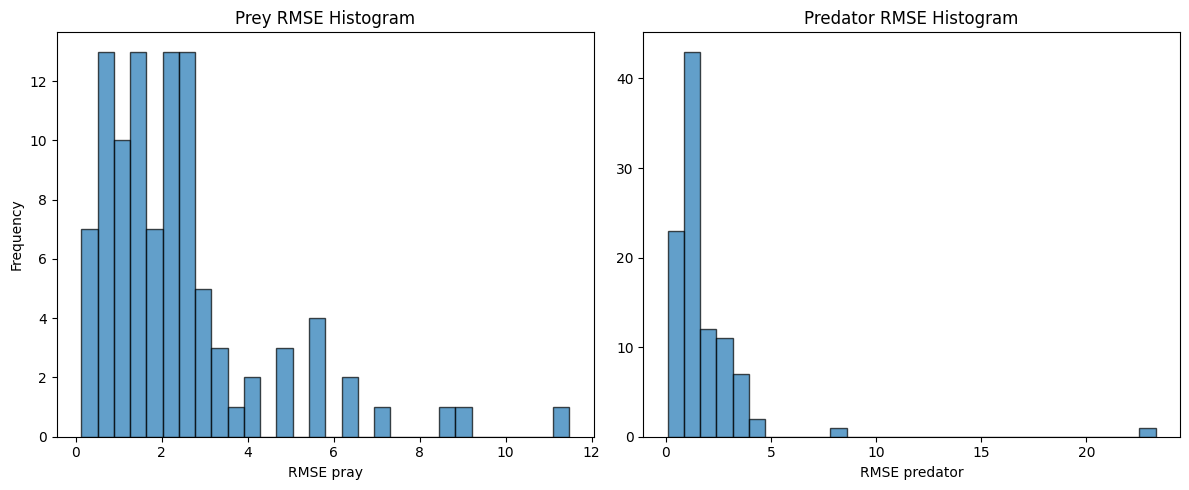

In [ ]:
plot_hist_MSE(mse_true_predicted_loaded,bins=30) # Plotting MSE distribution
plot_hist_RMSE(rmse_true_predicted_loaded,bins=30) # Plotting RMSE distribution

#### Step 7

Visualising one of the 100 predicted systems vs its true values.

From `src.plotting` we can import `PlotProject`, this is a class designed to host all the plotting codes that will be required for this project allowing us to save space in our notebook and keep it tidy.

For this particular casre we want to use `plot_pred_vs_true`, this will allow the user to plot the predicted prey vs predator population and compare it too true values for each system.

Decoded prediction shape: (100, 2)
True dataset shape: (100, 2)


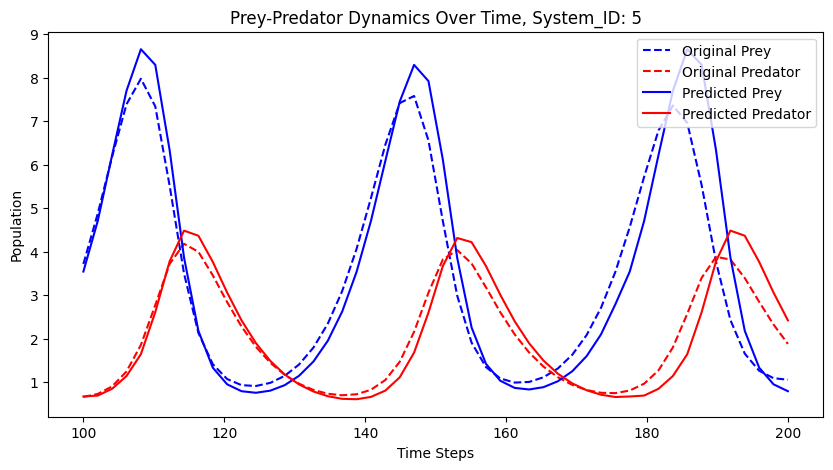

In [86]:
plot_pred_vs_true(my_decoded_predictions, traject_scaled_string, 5)# Plotting predicted vs true values

# Floating Point Operators (FLOPS for Baseline)

This section aims to provide an estimate of the total number of FLOPS utilised for Baseline.

## FLOPS Part 2(a):
- Scaling and Rounding of time series data
- Tokenisation of numeric sequence
- String conversion (prey, predator values into text format)

All the above FLOPS calculations are not provided, as according to the project instructions, hence we are invited to neglect them. What we should focus on instead is, determining the number of FLOPS for ML models.

## FLOPS Part 2(b)

For part 2(b), we need to consider the following calculation:
-	Only Forward Pass (we are feeding tokens to an untrained model)
-	No gradients, no backpropagation, no optimiser steps


For each token generated, the FLOPS of the forward pass can be estimated as
$$
\text{FLOPs per token} = \text{num\_layers} \times \left(\text{Attention FLOPs} + \text{Feedforward FLOPs} + \text{Normalization FLOPs} \right)
$$
Where:

- i. Self-Attention FLOPS is conmputed as
    $$
    \text{num\_heads} \times \text{seq\_length} \times d_{\text{model}} \times (2d_{\text{model}} - 1)
    $$

- ii. Feedforward FLOPS are computed as
    $$
    2 \times \text{seq\_length} \times d_{\text{model}} \times (2d_{\text{model}} - 1)
    $$

- iii. Total number of FLOPS per step is computed by multiplying by `num_kayers` and the total number of tokens generated.

These considerations are all implemented with the function `compute_generation_flops`, imported from the `flops.py` located in the directory `src`.


In [31]:
# Extract model parameters
num_heads = model.config.num_attention_heads
d_model = model.config.hidden_size
num_layers = model.config.num_hidden_layers

print(f"Number of attention heads: {num_heads}")
print(f"Number of hidden dimensions: {d_model}")
print(f"Number of Transformer layers: {num_layers}")

Number of attention heads: 14
Number of hidden dimensions: 896
Number of Transformer layers: 24


In [ ]:
from src.flops import compute_generation_flops # import required function

In [33]:
# Computing number of flops for part 2(b)

total_flops_2b = compute_generation_flops(input_ids_list, max_lengths)

print('Total number of FLOPS utilised for Baseline part 2(b):', total_flops_2b)

Total number of FLOPS utilised for Baseline part 2(b): 78407988019200


As we can see from the above output, the total number of FLOPS for just this section is approximately $8\times 10^{13}$. Which is way to much for this part of the project. I might have to cut it down a little!